# Experimental Design Simulation

This simulation parallels our 50-cycle MAGE experiment and allows exploring the relationship among experimental design parameters including number of oligos tested and number of clones sampled for genotyping. The simulation also investigated different number and effect-size distributions of causal mutations. For a given combination of parameters, we sample a distribution of underlying mutation effects (capped at a total fitness effect of 50%, comparable to the C321.∆A context) and then performed, in silico, iterations of MAGE separated by competitive expansion and bottlenecking of the population. We sample clonal genotypes from this simulated population and calculate phenotypes using the underlying mutation effects. We then perform predictive modeling with the simulated genotype-phenotype data and evaluate precision and recall relative to the underlying mutation effects. We also compare our linear modeling strategy to alternative modeling strategies of quantitative GWAS (a separate linear model for each variant) or using enrichment of mutations in the final population. We made simplifying assumptions of no de novo mutations, no epistatic interactions among mutations, no measurement noise, and equal recombination efficiency for all mutations.

In [1]:
import os
import random
import sys
import time

import ipyparallel as ipp
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

sys.path.append('../')
from common_code import simulation_util
from common_code.simulation_util import SimulationParams

## Implementation

We implement each component of the simulation as a separate function and perform a small sanity check / plot for the different steps below. The sanity checks build on the previous data.

NOTE: Most of the functions defintions have been extracted to common_code/simulation_util.py.

### Generate SNP effects

We'll assume some number of SNPs with an effect distributed according to a Gaussian, and then scaled so that the total effect comes out to < 50% total fitness defect.

We use multiplicative effects, e.g. a single mutant with effect 0.9 has 10% reduced doubling time.

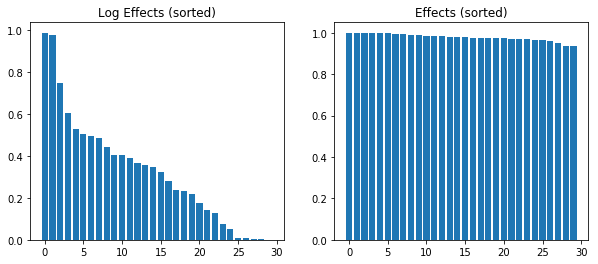

In [2]:
# Sanity check
test_non_zero_snp_effects = simulation_util.sample_effects_by_power_law(30, debug_plot=True)

Total Fitness 0.535284749388


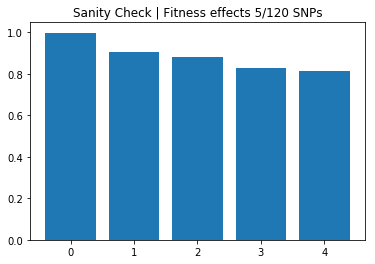

In [3]:
# Sanity check.
test_snp_effects = simulation_util.generate_snp_effects(
        simulation_util.DEFAULT_SNPS_CONSIDERED, simulation_util.DEFAULT_SNPS_WITH_EFFECT)
non_trivial_snp_effects = sorted([e for e in test_snp_effects if e != 1], reverse=True)
print 'Total Fitness', np.prod(non_trivial_snp_effects)
plt.figure()
plt.title('Sanity Check | Fitness effects %d/%d SNPs' % (
        simulation_util.DEFAULT_SNPS_WITH_EFFECT, simulation_util.DEFAULT_SNPS_CONSIDERED))
plt.bar(range(len(non_trivial_snp_effects)), non_trivial_snp_effects)
plt.show()

### Update population with MAGE

We'll need a function that performs a cycle of MAGE. We'll simplify this as updating some fraction of the population according to MAGE_EFFICIENCY, where that fraction of the population gets an additional mutation added on top.

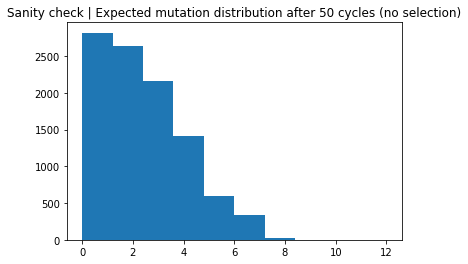

In [4]:
# Here we do a sanity check of the above by running 50 cycles of MAGE
# with 100 SNPs observing the resulting distribution of mutations.
# Note that we ignore selection based on fitness in between rounds.
# Initial population.
test_population = np.zeros(
    (simulation_util.DEFAULT_POPULATION_SIZE,
     simulation_util.DEFAULT_SNPS_CONSIDERED), dtype=np.bool)
for cycle in range(simulation_util.MAGE_CYCLES):
    test_population = simulation_util.update_population_with_mage_mutations(test_population)
plt.figure()
plt.title('Sanity check | Expected mutation distribution after 50 cycles (no selection)')
plt.hist(test_population.sum(axis=1))
plt.show()

### Calculate doubling times from genotype.

Now we need a way to generate doubling times for a population. This will be a function of the SNP effects with a bit of extra random noise.

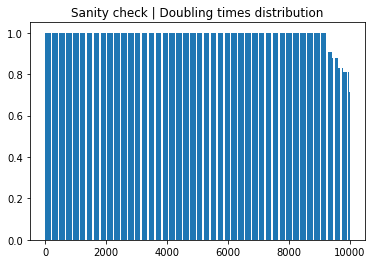

In [5]:
# Sanity check.
test_doubling_times = simulation_util.generate_doubling_times(
        test_population, test_snp_effects)
plt.figure()
plt.title('Sanity check | Doubling times distribution')
plt.bar(range(len(test_doubling_times)), sorted(test_doubling_times, reverse=True))
plt.show()

## Apply selection between MAGE cycles

For the model to actually work, we need to add some form of selection, so in between each MAGE cycle we'll do an expansion and pruning step that is weighted by the fitness effects.

We'll do this by allowing each genotype to double at a rate relative to the others proportional to its fitness.

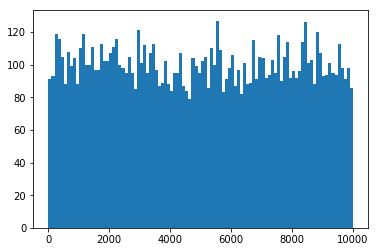

,descendents,doubling_times,growth_rates
1624,2278.467803,0.646725,1.546252
2919,1689.855182,0.672730,1.486480
327,1689.855182,0.672730,1.486480
662,1097.586689,0.714197,1.400174
9884,1097.586689,0.714197,1.400174
7553,1097.586689,0.714197,1.400174
7242,944.282108,0.729882,1.370085
6252,902.868421,0.734692,1.361115
3268,902.868421,0.734692,1.361115
4120,902.868421,0.734692,1.361115


In [6]:
# Sanity check.
# NOTE: We are running this on the final unselected population
# to see what would have been selected. See simulation with
# default params below for real end-to-end.
apply_selection_result = simulation_util.apply_selection_pressure(
        test_population, test_snp_effects)
subsampled_clones = apply_selection_result['subsampled_clone_ids'] 
plt.figure()
plt.hist(subsampled_clones, bins=100)
plt.show()
apply_selection_result['metadata_df'].sort_values('growth_rates', ascending=False)[:10]

### Run linear modeling and evaluate

In [7]:
# Sanity check.
test_lm_result = simulation_util.run_linear_modeling(
        test_population, test_doubling_times)

simulation_data = {
    'snp_effect': test_snp_effects,
}
lm_evaluation_results = simulation_util.evaluate_modeling_result(
        simulation_data, test_lm_result)
print 'Pearson: %f, p-value: %f' % (
        lm_evaluation_results['pearson_r'],
        lm_evaluation_results['p_value'])

lm_eval_results_df = lm_evaluation_results['results_df']
lm_eval_results_df[lm_eval_results_df['snp_effect'] != 1]

Pearson: 0.999996, p-value: 0.000000


,snp_effect,linear_model_coef
15,0.905528,0.906575
18,0.880268,0.881577
24,0.998222,0.998437
61,0.829159,0.829985
119,0.811341,0.813012


### Compare to GWAS

Quantitative GWAS is effectively running a linear model with a single SNP at a time. See `model_fitting#single_snp_lienar_modeling`.

../common_code/simulation_util.py:404: RuntimeWarning: divide by zero encountered in log10
  -np.log10(gwas_vs_lm_comparison_df['gwas_p']) /
../common_code/simulation_util.py:405: RuntimeWarning: divide by zero encountered in log10
  np.max(-np.log10(gwas_vs_lm_comparison_df['gwas_p']))),


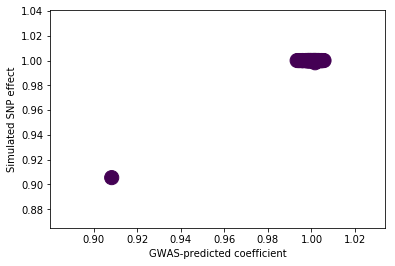

GWAS Pearson: 0.995491, p-value: 0.000000
GWAS results | SNPs with effect or p < 0.05


,snp_effect,gwas_coef,gwas_p
119,0.811341,0.814186,0.000000e+00
61,0.829159,0.834392,0.000000e+00
18,0.880268,0.883492,0.000000e+00
15,0.905528,0.908340,1.134804e-240
24,0.998222,1.001648,1.000000e+00


In [8]:
# Sanity check.
gwas_results_df = simulation_util.run_gwas(test_population, test_doubling_times)
gwas_eval_results = simulation_util.evaluate_gwas_result(
        gwas_results_df, lm_eval_results_df, show_plot=True)
gwas_eval_results_df = gwas_eval_results['results_df']

print 'GWAS Pearson: %f, p-value: %f' % (
        gwas_eval_results['pearson_r'],
        gwas_eval_results['p_value'])

print 'GWAS results | SNPs with effect or p < 0.05'
gwas_results_of_interest_df = gwas_eval_results_df[
        (gwas_eval_results_df['snp_effect'] < 1) |
        (gwas_eval_results_df['gwas_p'] < 0.05)]
gwas_results_of_interest_df = gwas_results_of_interest_df[[
        'snp_effect', 'gwas_coef', 'gwas_p']].sort_values('snp_effect')
display(gwas_results_of_interest_df)

Here we define some functions for calculating metrics like true positives, false positives, recall, etc.

In [9]:
print 'Linear modeling'
print simulation_util.calculate_modeling_metrics(lm_eval_results_df, 'linear_model_coef', 'lm_')

print '\nGWAS'
print simulation_util.calculate_modeling_metrics(gwas_eval_results_df, 'gwas_coef', 'gwas_')

Linear modeling
{'lm_weighted_precision': 1.0, 'lm_sim_false': 115, 'lm_largest_effect_detected': 0.81134076494962859, 'lm_precision': 1.0, 'lm_observed_false': 115, 'lm_total_effect_detected': 0.53528474938815918, 'lm_observed_true': 5, 'lm_true_negatives': 115, 'lm_false_positives': 0, 'lm_percent_of_total_effect_detected': 1.0, 'lm_recall': 1.0, 'lm_specificity': 1.0, 'lm_sim_true': 5, 'lm_false_positive_rate': 0.0, 'lm_weighted_recall': 1.0, 'lm_true_positives': 5, 'lm_false_negatives': 0, 'lm_smallest_effect_detected': 0.9982224121730171}

GWAS
{'gwas_sim_false': 115, 'gwas_observed_false': 116, 'gwas_recall': 0.8, 'gwas_total_effect_detected': 0.5362379594572565, 'gwas_smallest_effect_detected': 0.90552775441371192, 'gwas_false_positives': 0, 'gwas_percent_of_total_effect_detected': 0.99794882980956112, 'gwas_largest_effect_detected': 0.81134076494962859, 'gwas_true_positives': 4, 'gwas_sim_true': 5, 'gwas_false_positive_rate': 0.0, 'gwas_weighted_recall': 0.99794882980956112, 'g

Slightly different metrics for enrichment.

In [10]:
# Sanity check
test_simulation_data = {
    'sim_params': SimulationParams(),
    'final_population': test_population,
    'final_doubling_times': test_doubling_times,
    'snp_effect': test_snp_effects,
}
test_enrichment_result_df = simulation_util.run_enrichment_analysis(test_simulation_data)

simulation_util.calculate_enrichment_metrics(test_enrichment_result_df)

{'enrichment_false_negatives': 5,
 'enrichment_false_positive_rate': 0.3652173913043478,
 'enrichment_false_positives': 42,
 'enrichment_largest_effect_detected': 1.0,
 'enrichment_observed_false': 78,
 'enrichment_observed_true': 42,
 'enrichment_percent_of_total_effect_detected': 0.0,
 'enrichment_precision': 0.0,
 'enrichment_recall': 0.0,
 'enrichment_sim_false': 115,
 'enrichment_sim_true': 5,
 'enrichment_smallest_effect_detected': 1.0,
 'enrichment_specificity': 0.6347826086956522,
 'enrichment_total_effect_detected': 1.0,
 'enrichment_true_negatives': 73,
 'enrichment_true_positives': 0}

## Run simulations

First, test our re-useable function for running simulations.

In [11]:
# Sanity checks.
test_sim_params = SimulationParams()
test_sim_params.population_size = 100
test_run_simulation_result = simulation_util.run_simulation(
        simulation_params=test_sim_params)
assert min(test_run_simulation_result['wgs_samples_mage_cycle_list']) == 1
assert max(test_run_simulation_result['wgs_samples_mage_cycle_list']) == 50

test_sim_params = SimulationParams()
test_sim_params.population_size = 100
test_sim_params.num_samples = 5
test_run_simulation_result = simulation_util.run_simulation(
        simulation_params=test_sim_params)
np.testing.assert_array_equal(
        np.array([10, 20, 30, 40, 50]),
        np.array(test_run_simulation_result['wgs_samples_mage_cycle_list']))

### Simulation with our default experiment parameters.

Total Fitness Defect 0.503215015493


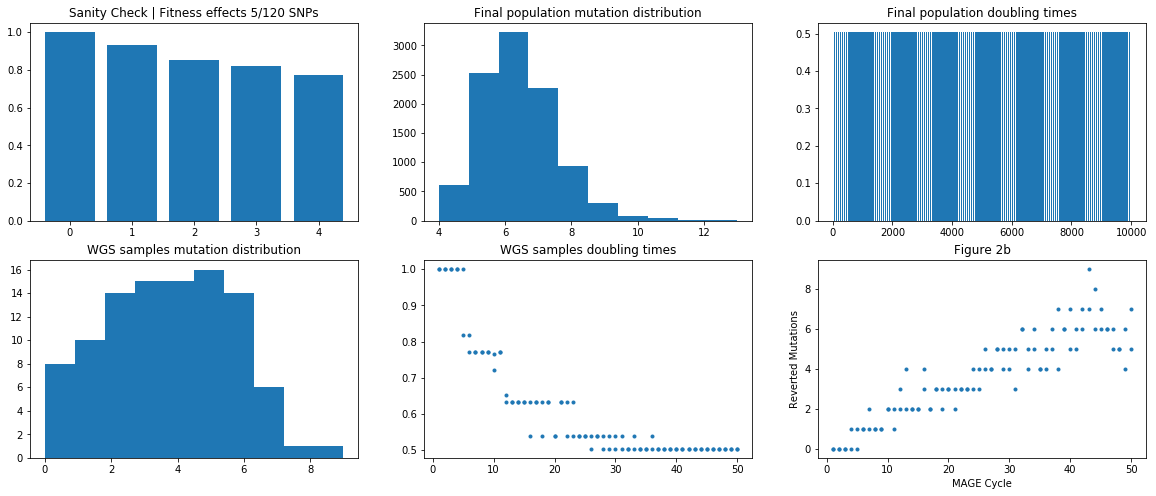

>>> Linear Model Results
Pearson: 0.989589, p-value: 0.000000


,snp_effect,linear_model_coef
25,0.933610,0.958055
51,0.853713,0.912777
69,0.999252,1.000000
82,0.819297,0.847623
118,0.771186,0.796425


>>> GWAS results


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/stats.py:3027: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1-r*r)*ssym / ssxm / df)


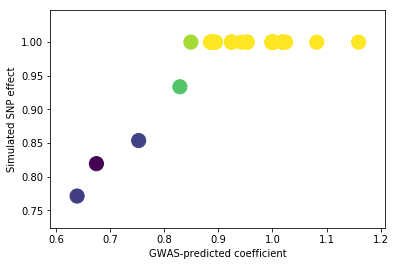

GWAS Pearson: 0.668649, p-value: 0.000000
GWAS results | SNPs with effect or p < 0.05


,snp_effect,gwas_coef,gwas_p
118,0.771186,0.639217,1.430678e-21
82,0.819297,0.674895,5.065867e-26
51,0.853713,0.752957,4.748257e-21
25,0.933610,0.829112,1.375046e-07
69,0.999252,1.000000,1.000000e+00
109,1.000000,0.849383,4.268947e-04


GWAS results | SNPs with effect or p < 0.05


,snp_effect,gwas_coef,gwas_p
118,0.771186,0.639217,1.430678e-21
82,0.819297,0.674895,5.065867e-26
51,0.853713,0.752957,4.748257e-21
25,0.933610,0.829112,1.375046e-07
69,0.999252,1.000000,1.000000e+00
109,1.000000,0.849383,4.268947e-04


In [12]:
sim_params = SimulationParams()
default_simulation_result = simulation_util.run_simulation(
        simulation_params=sim_params)
simulation_util.visualize_simulation_result(default_simulation_result)

# Perform linear modeling.
print '>>> Linear Model Results'
test_lm_result = simulation_util.run_linear_modeling(
        default_simulation_result['wgs_samples'],
        default_simulation_result['wgs_samples_doubling_times'],
        repeats=10)
lm_eval_results = simulation_util.evaluate_modeling_result(
        default_simulation_result, test_lm_result)
lm_eval_results_df = lm_eval_results['results_df']

print 'Pearson: %f, p-value: %f' % (
        lm_eval_results['pearson_r'], lm_eval_results['p_value'])
display(lm_eval_results_df[lm_eval_results_df['snp_effect'] != 1])

# Compare to GWAS
print '>>> GWAS results'
gwas_results_df = simulation_util.run_gwas(
        default_simulation_result['wgs_samples'],
        default_simulation_result['wgs_samples_doubling_times'])
gwas_eval_results = simulation_util.evaluate_gwas_result(
        gwas_results_df, lm_eval_results_df, show_plot=True)
gwas_eval_results_df = gwas_eval_results['results_df']

print 'GWAS Pearson: %f, p-value: %f' % (
        gwas_eval_results['pearson_r'],
        gwas_eval_results['p_value'])

print 'GWAS results | SNPs with effect or p < 0.05'
gwas_results_of_interest_df = gwas_eval_results_df[
        (gwas_eval_results_df['snp_effect'] < 1) |
        (gwas_eval_results_df['gwas_p'] < 0.05)]
gwas_results_of_interest_df = gwas_results_of_interest_df[[
        'snp_effect', 'gwas_coef', 'gwas_p']].sort_values('snp_effect')
display(gwas_results_of_interest_df)
print 'GWAS results | SNPs with effect or p < 0.05'
gwas_results_of_interest_df = gwas_eval_results_df[
        (gwas_eval_results_df['snp_effect'] < 1) |
        (gwas_eval_results_df['gwas_p'] < 0.05)]
gwas_results_of_interest_df = gwas_results_of_interest_df[[
        'snp_effect', 'gwas_coef', 'gwas_p']].sort_values('snp_effect')
display(gwas_results_of_interest_df)

### Compare with same SNP effects against no selection.

>>>With Selection
Total Fitness Defect 0.476722689703


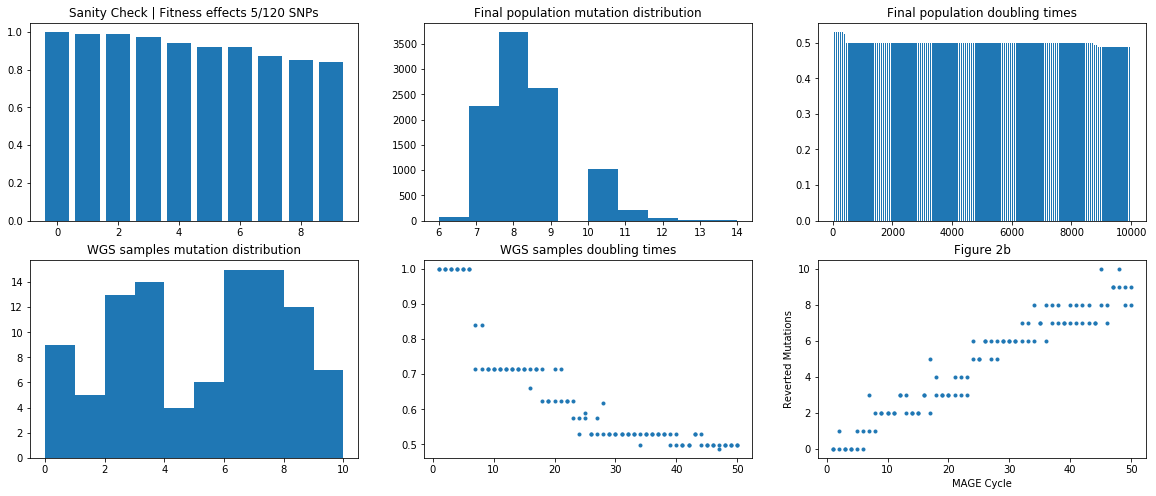

Pearson: 0.977409, p-value: 0.000000


,snp_effect,linear_model_coef
37,0.989039,0.999673
41,0.850607,0.873029
75,0.942631,0.969379
77,0.998373,1.000000
79,0.919339,0.954531
88,0.991224,1.000000
92,0.921640,0.956400
96,0.841160,0.843653
103,0.976052,0.995285
113,0.873230,0.908679


>>>No Selection
Total Fitness Defect 0.476722689703


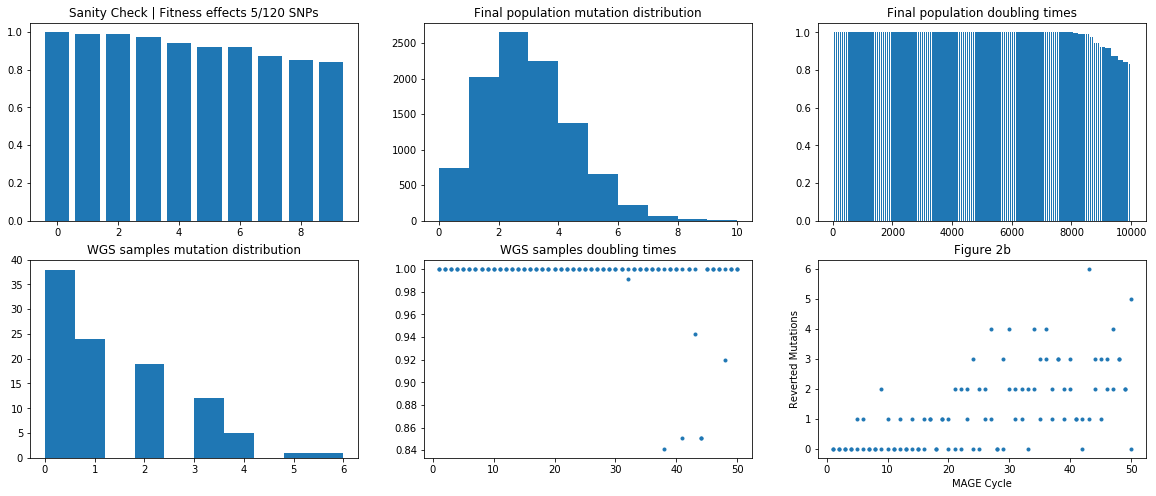

Pearson: 0.778030, p-value: 0.000000


,snp_effect,linear_model_coef
37,0.989039,1.000000
41,0.850607,0.853981
75,0.942631,0.974635
77,0.998373,1.000000
79,0.919339,1.000000
88,0.991224,1.000000
92,0.921640,1.000000
96,0.841160,0.850864
103,0.976052,1.000000
113,0.873230,1.000000


In [13]:
sim_params = SimulationParams()

sim_params.num_snps_with_effect = 10
simulation_result_with_selection = simulation_util.run_simulation(
        simulation_params=sim_params)
simulation_result_no_selection = simulation_util.run_simulation(
        simulation_params=sim_params,
        snp_effects=simulation_result_with_selection['snp_effect'],
        should_apply_selection_pressure=False)

print '>>>With Selection'
simulation_util.visualize_simulation_result(simulation_result_with_selection)

# Perform linear modeling.
test_lm_result = simulation_util.run_linear_modeling(
        simulation_result_with_selection['wgs_samples'],
        simulation_result_with_selection['wgs_samples_doubling_times'],
        repeats=10)

# Evaluate results.
evaluation_results = simulation_util.evaluate_modeling_result(
        simulation_result_with_selection, test_lm_result)
print 'Pearson: %f, p-value: %f' % (evaluation_results['pearson_r'], evaluation_results['p_value'])
eval_results_df = evaluation_results['results_df']
display(eval_results_df[eval_results_df['snp_effect'] != 1])

with_selection_modeling_metrics = {
    'lm_pearson_r': evaluation_results['pearson_r'],
    'lm_pearson_p': evaluation_results['p_value'],
}
with_selection_modeling_metrics.update(
        simulation_util.calculate_modeling_metrics(
                eval_results_df, 'linear_model_coef',
                results_prefix='lm_'))

print '>>>No Selection'
simulation_util.visualize_simulation_result(simulation_result_no_selection)

test_lm_result = simulation_util.run_linear_modeling(
        simulation_result_no_selection['wgs_samples'],
        simulation_result_no_selection['wgs_samples_doubling_times'],
        max_iter=300,  # This converges poorly so manually limit here for now.
        repeats=1)  # likewise

# Evaluate results.
evaluation_results = simulation_util.evaluate_modeling_result(simulation_result_no_selection, test_lm_result)
print 'Pearson: %f, p-value: %f' % (evaluation_results['pearson_r'], evaluation_results['p_value'])
eval_results_df = evaluation_results['results_df']
display(eval_results_df[eval_results_df['snp_effect'] != 1])

no_selection_modeling_metrics = {
    'lm_pearson_r': evaluation_results['pearson_r'],
    'lm_pearson_p': evaluation_results['p_value'],
}
no_selection_modeling_metrics.update(
        simulation_util.calculate_modeling_metrics(
                eval_results_df, 'linear_model_coef',
                results_prefix='lm_'))

Also compare linear modeling result if we had just taken all samples from last timepoint, instead of sampling across different MAGE cycles.

Pearson: 0.199114, p-value: 0.029240


,snp_effect,linear_model_coef
37,0.989039,1.000000
41,0.850607,1.000000
75,0.942631,0.969776
77,0.998373,1.000000
79,0.919339,1.000000
88,0.991224,0.995635
92,0.921640,1.000000
96,0.841160,1.000000
103,0.976052,0.988061
113,0.873230,1.000000


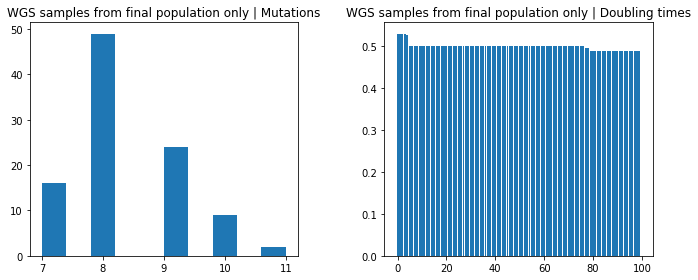

In [14]:
# Sub-sample final population.
final_timepoint_subsample = np.zeros(
        (simulation_util.DEFAULT_NUM_SAMPLES, simulation_util.DEFAULT_SNPS_CONSIDERED), dtype=np.bool)
random_indeces_from_final_population = np.random.choice(
        range(len(simulation_result_with_selection['final_population'])),
        size=simulation_util.DEFAULT_NUM_SAMPLES)
final_timepoint_doubling_times = []
for i, random_idx in enumerate(random_indeces_from_final_population):
    final_timepoint_subsample[i,:] = (
            simulation_result_with_selection['final_population'][random_idx,:])
    final_timepoint_doubling_times.append(
            simulation_result_with_selection['final_doubling_times'][random_idx])
assert final_timepoint_subsample.shape == (
        simulation_util.DEFAULT_NUM_SAMPLES,
        simulation_util.DEFAULT_SNPS_CONSIDERED)
assert len(final_timepoint_doubling_times) == simulation_util.DEFAULT_NUM_SAMPLES

# Run linear modeling.
test_lm_result = simulation_util.run_linear_modeling(
        final_timepoint_subsample,
        final_timepoint_doubling_times,
        repeats=1,
        max_iter=300)

# Evaluate results.
evaluation_results = simulation_util.evaluate_modeling_result(
        simulation_result_with_selection, test_lm_result)
print 'Pearson: %f, p-value: %f' % (evaluation_results['pearson_r'], evaluation_results['p_value'])
eval_results_df = evaluation_results['results_df']
display(eval_results_df[eval_results_df['snp_effect'] != 1])

final_timepoint_modeling_metrics = {
    'lm_pearson_r': evaluation_results['pearson_r'],
    'lm_pearson_p': evaluation_results['p_value'],
}
final_timepoint_modeling_metrics.update(
        simulation_util.calculate_modeling_metrics(
                eval_results_df, 'linear_model_coef',
                results_prefix='lm_'))

plt.figure(figsize=(10, 4))

# WGS mutation distribution
plt.subplot(1, 2, 1)
plt.title('WGS samples from final population only | Mutations')
plt.hist(final_timepoint_subsample.sum(axis=1))

# WGS doubling times
plt.subplot(1, 2, 2)
plt.title('WGS samples from final population only | Doubling times')
plt.bar(
        range(len(final_timepoint_doubling_times)),
        sorted(final_timepoint_doubling_times, reverse=True),
        edgecolor="none")
plt.tight_layout()

plt.show()

Output for plotting in R.

In [15]:
IGNORE_KEYS = ['sim_params', 'final_population']

# 4a
supp_fig4a_data_dir = 'results/supp_fig4a_data'
for key in simulation_result_with_selection.keys():
    if key in IGNORE_KEYS:
        continue
    np.savetxt(
            os.path.join(supp_fig4a_data_dir, key + '.csv'),
            simulation_result_with_selection[key],
            delimiter=',')
pd.DataFrame([with_selection_modeling_metrics]).to_csv(
        os.path.join(supp_fig4a_data_dir, 'modeling_metrics.csv'),
        index=False)
    
# 4b
supp_fig4b_data_dir = 'results/supp_fig4b_data'
np.savetxt(
        os.path.join(supp_fig4b_data_dir, 'wgs_samples.csv'),
        final_timepoint_subsample,
        delimiter=',')
np.savetxt(
        os.path.join(supp_fig4b_data_dir, 'wgs_samples_doubling_times.csv'),
        final_timepoint_doubling_times,
        delimiter=',')
pd.DataFrame([final_timepoint_modeling_metrics]).to_csv(
        os.path.join(supp_fig4b_data_dir, 'modeling_metrics.csv'),
        index=False)

# 4c
supp_fig4c_data_dir = 'results/supp_fig4c_data'
for key in simulation_result_no_selection.keys():
    if key in IGNORE_KEYS:
        continue
    np.savetxt(
            os.path.join(supp_fig4c_data_dir, key + '.csv'),
            simulation_result_no_selection[key],
            delimiter=',')
pd.DataFrame([no_selection_modeling_metrics]).to_csv(
        os.path.join(supp_fig4c_data_dir, 'modeling_metrics.csv'),
        index=False)

Placeholder plot for Fig S4a-c for co-authors review.

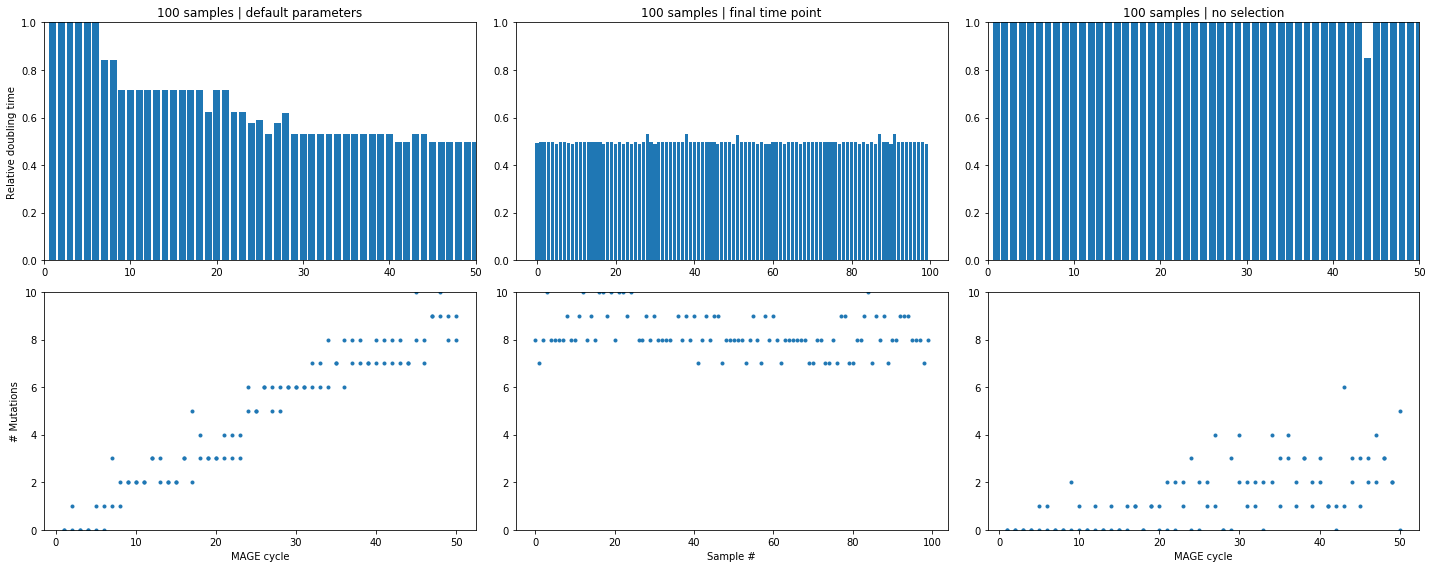

In [16]:
plt.figure(figsize=(20, 8))

final_timepoint_doubling_times
final_timepoint_subsample

### S4A
plt.subplot(2, 3, 1)
plt.title('100 samples | default parameters')
plt.bar(
        simulation_result_with_selection['wgs_samples_mage_cycle_list'],
        simulation_result_with_selection['wgs_samples_doubling_times'],
)
plt.ylabel("Relative doubling time")
plt.xlim((0, 50))
plt.ylim((0, 1.0))

plt.subplot(2, 3, 4)
plt.plot(
        simulation_result_with_selection['wgs_samples_mage_cycle_list'],
        np.sum(simulation_result_with_selection['wgs_samples'], axis=1),
        '.')
plt.ylabel("# Mutations")
plt.xlabel('MAGE cycle')
plt.ylim((0, 10))

### S4B
plt.subplot(2, 3, 2)
plt.title('100 samples | final time point')
plt.bar(
        range(len(final_timepoint_doubling_times)),
        final_timepoint_doubling_times,
)
plt.ylim((0, 1.0))

plt.subplot(2, 3, 5)
plt.plot(
        range(len(final_timepoint_subsample)),
        np.sum(final_timepoint_subsample, axis=1),
        '.'
)
plt.xlabel('Sample #')
plt.ylim((0, 10))

### S4C
plt.subplot(2, 3, 3)
plt.title('100 samples | no selection')
plt.bar(
        simulation_result_no_selection['wgs_samples_mage_cycle_list'],
        simulation_result_no_selection['wgs_samples_doubling_times'],
)
plt.xlim((0, 50))
plt.ylim((0, 1.0))

plt.subplot(2, 3, 6)
plt.plot(
        simulation_result_no_selection['wgs_samples_mage_cycle_list'],
        np.sum(simulation_result_no_selection['wgs_samples'], axis=1),
        '.')
plt.xlabel('MAGE cycle')
plt.ylim((0, 10))

plt.tight_layout()
plt.rcParams.update({'font.size': 18})

plt.savefig('results/supp_fig_4abc_ipynb_draft.png', dpi=300)

plt.show()

Also look at what using enrichment at final timepoint would give.

In [17]:
final_timepoint_enrichment_with_selection_df = pd.DataFrame({
    'snp_effect': simulation_result_with_selection['snp_effect'],
    'enrichment_count': final_timepoint_subsample.sum(axis=0)
})

display(final_timepoint_enrichment_with_selection_df.sort_values(
        'enrichment_count', ascending=False)[:10])

,enrichment_count,snp_effect
113,100,0.873230
79,100,0.919339
41,100,0.850607
96,100,0.841160
92,100,0.921640
69,100,1.000000
75,95,0.942631
103,21,0.976052
14,13,1.000000
20,5,1.000000


To call a SNP by enrichment, let's say its enrichment has to be above the average.

In [18]:
simulation_util.calculate_enrichment_metrics(final_timepoint_enrichment_with_selection_df)

{'enrichment_false_negatives': 3,
 'enrichment_false_positive_rate': 0.018181818181818188,
 'enrichment_false_positives': 2,
 'enrichment_largest_effect_detected': 0.84115965118015779,
 'enrichment_observed_false': 111,
 'enrichment_observed_true': 9,
 'enrichment_percent_of_total_effect_detected': 0.980233822051776,
 'enrichment_precision': 0.7777777777777778,
 'enrichment_recall': 0.7,
 'enrichment_sim_false': 110,
 'enrichment_sim_true': 10,
 'enrichment_smallest_effect_detected': 0.97605169157646787,
 'enrichment_specificity': 0.9818181818181818,
 'enrichment_total_effect_detected': 0.48706588213496071,
 'enrichment_true_negatives': 108,
 'enrichment_true_positives': 7}

This does decently well at our parameters, but misses at least one and gives at least one false positive. This might be an okay strategy at our design parameters, but we should show below that this is not as good with other design parameters.

## Perform simulations across different parameters and record performance

We'll use ipyparallel to parallelize. To start a local cluster, run this in a terminal:

    ipcluster start -n <num_cores>

In [19]:
ipp_client = ipp.Client()

Use load-balanced view which distributes jobs as you would expect.

In [20]:
lbv = ipp_client.load_balanced_view()

**With more strains tested, would it be possible to identify more variants that affect fitness?**

In [21]:
# Clones sequenced.
# num_samples_range = [24, 48, 72, 96, 144, 192, 240, 288, 336, 384]  # For manuscript
num_samples_range = [24, 48]  # For test
print '\nnum_samples_range'
print num_samples_range

# Total oligos.
# num_snps_considered_range = (
#         list(range(10, 100, 10)) +
#         list(range(100, 600, 100)) +
#         list(range(600, 1001, 200))
# )  # For manuscript
num_snps_considered_range = [10, 20]  # For test
print '\nnum_snps_considered'
print num_snps_considered_range

# Causal SNPs.
# Bounded in the foor loop to be less than num_snps_considered.
# num_snps_with_effect_range = [5] + list(range(10, 101, 10))  # For manuscript
num_snps_with_effect_range = range(5, 11, 1)  # For test
print '\nnum_snps_with_effect_range'
print num_snps_with_effect_range

# NUM_SNPS_SAMPLES_GRID_REPLICATES = 10  # For manuscript
NUM_SNPS_SAMPLES_GRID_REPLICATES = 1  # For test

# NUM_LM_REPEATS = 10  # For manuscript
NUM_LM_REPEATS = 1  # For test

# Estimated time
print 'Estimated simulations < %d' % (
        len(num_samples_range) * len(num_snps_considered_range) *
        len(num_snps_with_effect_range) * NUM_SNPS_SAMPLES_GRID_REPLICATES)


num_samples_range
[24, 48]

num_snps_considered
[10, 20]

num_snps_with_effect_range
[5, 6, 7, 8, 9, 10]
Estimated simulations < 24


In [22]:
more_strains_simulation_async_results = []
for num_snps_considered in num_snps_considered_range:
    for num_samples in num_samples_range:
        for num_snps_with_effect in num_snps_with_effect_range: 
            if num_snps_with_effect >= num_snps_considered:
                continue
            for rep in range(1, NUM_SNPS_SAMPLES_GRID_REPLICATES + 1):
                sim_params = simulation_util.SimulationParams()
                sim_params.num_snps_with_effect = num_snps_with_effect
                sim_params.num_samples = num_samples
                sim_params.num_snps_considered = num_snps_considered
                more_strains_simulation_async_results.append(
                        lbv.apply_async(
                                simulation_util.run_simulation_with_params,
                                sim_params, rep, repeats=NUM_LM_REPEATS))
                
print 'Started %d jobs' % len(more_strains_simulation_async_results)

# Loop to write results that are finished at this point.
while True:
    more_strains_simulation_result = []
    for ar in more_strains_simulation_async_results:
        if ar.ready():
            more_strains_simulation_result.append(ar.get())
            
    # Write result so far.
    more_strains_simulation_result_df = pd.DataFrame(
            more_strains_simulation_result)
    if len(more_strains_simulation_result_df):
        more_strains_simulation_result_df = more_strains_simulation_result_df[
                simulation_util.SIM_RESULT_KEY_ORDER]
        more_strains_simulation_result_df.to_csv(
                'results/sim_results_num_strains_vs_num_snps_identified_small_test.csv',
                index=False)

    # Check if all ready.
    if len(more_strains_simulation_result) == len(more_strains_simulation_async_results):
        break
        
    # Delay 30 seconds until next check.
    time.sleep(30)

more_strains_simulation_result_df[:3]

Started 22 jobs


,num_snps_considered,num_samples,num_snps_with_effect,replicate,mage_cycles,population_size,total_fitness_effect,lm_pearson_r,lm_pearson_p,lm_true_positives,...,enrichment_true_negatives,enrichment_false_negatives,enrichment_precision,enrichment_recall,enrichment_specificity,enrichment_false_positive_rate,enrichment_smallest_effect_detected,enrichment_largest_effect_detected,enrichment_total_effect_detected,enrichment_percent_of_total_effect_detected
0,10,24,5,1,50,10000,0.502072,0.978289,9.469851e-07,5,...,5,1,1.0,0.800000,1.0,0.0,0.907791,0.722277,0.502631,0.998878
1,10,24,6,1,50,10000,0.471295,0.639410,4.652147e-02,5,...,4,1,1.0,0.833333,1.0,0.0,0.988263,0.780240,0.473292,0.996223
2,10,24,7,1,50,10000,0.443739,0.356202,3.123736e-01,6,...,3,0,1.0,1.000000,1.0,0.0,0.984631,0.684800,0.443739,1.000000
